In [34]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import torch
import os
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as torch_datasets

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA

from models import LAVAE, torch_dataloader, torch_latent_dataloader
import utils as ut
import train_utils as tu
import scipy

# Autoreload
%load_ext autoreload
%autoreload 2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results_folder = os.path.join('Results', 'Test')
checkpoints_folder = os.path.join(results_folder, 'Checkpoints')
plots_folder = os.path.join(results_folder, 'Plots')
print(results_folder)
if not os.path.exists(results_folder): 
    os.makedirs(results_folder)
    os.makedirs(checkpoints_folder)
    os.makedirs(plots_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Results/Test


In [3]:
# Load Model and Data
checkpoints_folder = os.path.join('Results', 'flips_to6', 'Checkpoints')
model_f = torch.load(os.path.join(checkpoints_folder, 'Decs_6_100.pt'),map_location=device)

_, test_loader = ut.MNIST_data(class_filter=None,augs=['flip_lr', 'flip_ud'],combine=False,targets=False)

## Trace Recursive Samples

(10000, 16)
(10000, 16)
(10000, 16)
(10000, 16)
(10000, 16)


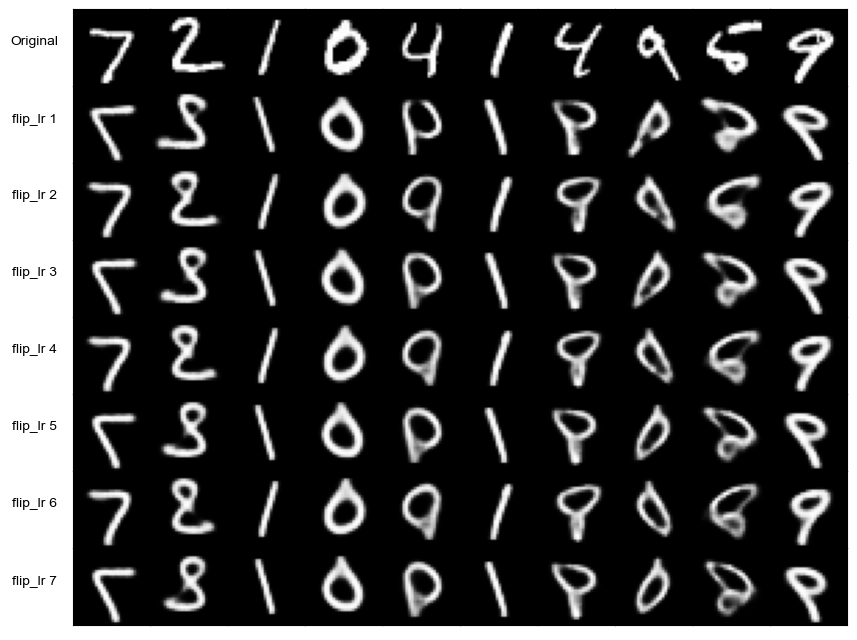

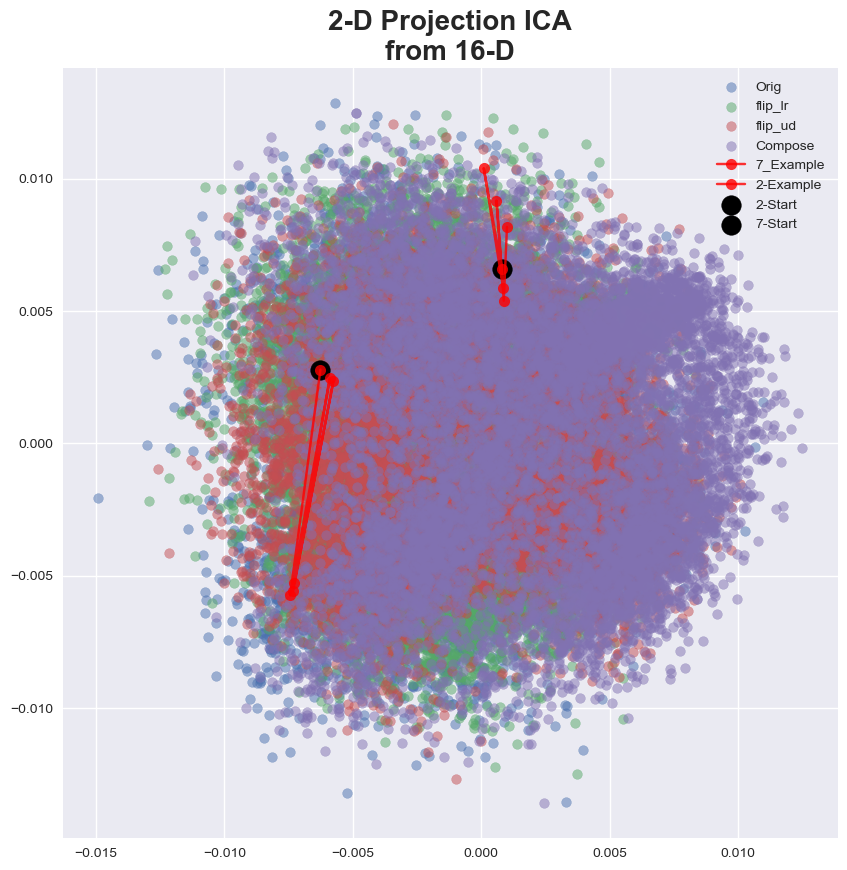

In [68]:
def plot_Laug_Recon(model, test_loader, device, augs, decoder=0, num_samples=2, save_path=None):
    
    model.eval()

    plt.style.use('default')


    fig, ax = plt.subplots(8, num_samples, figsize=(num_samples, 8))


    x_laugs = {}
    x_hat = {}
    z = {}

    x = next(iter(test_loader))

    for aug in x.keys(): 
        x[aug] = x[aug].to(device)
        x_hat[aug], z[aug], _ = model(x[aug])

    x_laugs['orig'] = x_hat['orig']

    # Run through the 1st augmentation 6 times
    x_laugs[augs[0] + '_{}'.format(1)] = model.decoders[decoder](z['orig']@ model.Laugs[0])
    for i in range(1,7):
        x_hat[aug], z[augs[0] + '_{}'.format(i)],_ = model(x_laugs[augs[0] + '_{}'.format(i)])
        x_laugs[augs[0] + '_{}'.format(i+1)] = model.decoders[decoder](z[augs[0] + '_{}'.format(i)] @ model.Laugs[0])


    rotation = 0
    if len(model.Laugs) == 2:
        for i in range(num_samples):
            ax[0, i].imshow(x['orig'][i].cpu().detach().numpy().squeeze(), cmap='gray')
            ax[1, i].imshow(x_laugs[augs[0] + '_{}'.format(1)][i].cpu().detach().numpy().squeeze(), cmap='gray')
            ax[2, i].imshow(x_laugs[augs[0] + '_{}'.format(2)][i].cpu().detach().numpy().squeeze(), cmap='gray')
            ax[3, i].imshow(x_laugs[augs[0] + '_{}'.format(3)][i].cpu().detach().numpy().squeeze(), cmap='gray')
            ax[4, i].imshow(x_laugs[augs[0] + '_{}'.format(4)][i].cpu().detach().numpy().squeeze(), cmap='gray')
            ax[5, i].imshow(x_laugs[augs[0] + '_{}'.format(5)][i].cpu().detach().numpy().squeeze(), cmap='gray')
            ax[6, i].imshow(x_laugs[augs[0] + '_{}'.format(6)][i].cpu().detach().numpy().squeeze(), cmap='gray')
            ax[7, i].imshow(x_laugs[augs[0] + '_{}'.format(7)][i].cpu().detach().numpy().squeeze(), cmap='gray')

            if i == 0:
                ax[0, i].set_ylabel('Original',rotation=rotation)
                ax[1, i].set_ylabel('{} 1'.format(augs[0]),rotation=rotation)
                ax[2, i].set_ylabel('{} 2'.format(augs[0]),rotation=rotation)
                ax[3, i].set_ylabel('{} 3'.format(augs[0]),rotation=rotation)
                ax[4, i].set_ylabel('{} 4'.format(augs[0]),rotation=rotation)
                ax[5, i].set_ylabel('{} 5'.format(augs[0]),rotation=rotation)
                ax[6, i].set_ylabel('{} 6'.format(augs[0]),rotation=rotation)
                ax[7, i].set_ylabel('{} 7'.format(augs[0]),rotation=rotation)

            for j in range(8):
                if i == 0: ax[j, i].yaxis.set_label_coords(-0.5,0.5)
                ax[j, i].set_xticks([])
                ax[j, i].set_yticks([])


    plt.subplots_adjust(wspace=0, hspace=0)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

    return z

    
_, test_loader = ut.MNIST_data(class_filter=None,augs=['flip_lr', 'flip_ud'],combine=False,targets=False)
z = plot_Laug_Recon(model_f, test_loader, device, ['flip_lr', 'flip_ud'], decoder=0, num_samples=10, save_path=None)
_, test_loader = ut.MNIST_data(class_filter=None,augs=['flip_lr', 'flip_ud'],combine=True,targets=True)
pca, tsne, ica = ut.plot_2D_tSNE_latent(model_f, test_loader, device,['flip_lr', 'flip_ud'], decoder=0, save_path=None)

outs = []
outs.append(ica.transform(z['flip_lr_1'].cpu().detach().numpy()))
outs.append(ica.transform(z['flip_lr_2'].cpu().detach().numpy()))
outs.append(ica.transform(z['flip_lr_3'].cpu().detach().numpy()))
outs.append(ica.transform(z['flip_lr_4'].cpu().detach().numpy()))
outs.append(ica.transform(z['flip_lr_5'].cpu().detach().numpy()))
outs.append(ica.transform(z['flip_lr_6'].cpu().detach().numpy()))

outs = np.array(outs)

# Plot the 2D latent space
plt.plot(outs[:,0,0], outs[:,0,1], c='r', label='7_Example',marker='o',markersize=8,alpha=0.8)
plt.plot(outs[:,1,0], outs[:,1,1], c='r', label='2-Example',marker='o',markersize=8,alpha=0.8)
plt.scatter(outs[0,1,0], outs[0,1,1], c='k', label='2-Start',marker='o',s=200)
plt.scatter(outs[0,0,0], outs[0,0,1], c='k', label='7-Start',marker='o',s=200)
plt.legend()

## Interpolate and Sample

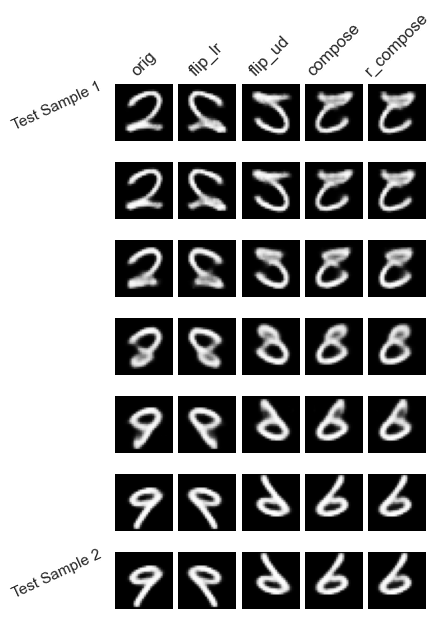

In [43]:
_, test_loader = ut.MNIST_data(class_filter=None,augs=['flip_lr', 'flip_ud'],combine=False,targets=False)
ut.interpolate(model_f, test_loader, device, ['flip_lr', 'flip_ud'], decoder=0, n_steps=5)

In [ ]:
# train_loader, test_loader = ut.MNIST_data(class_filter=None,augs=['flip_lr', 'flip_ud'],combine=True,targets=True)
ut.sample_latent(model_f,train_loader, device, ['flip_lr', 'flip_ud'], decoder=0, num_samples=2)
# ut.sample_latent(model_f,train_loader, device, ['flip_lr', 'flip_ud'], decoder=0, num_samples=2)
# ut.sample_latent(model_f,train_loader, device, ['flip_lr', 'flip_ud'], decoder=0, num_samples=2)
# ut.sample_latent(model_f,train_loader, device, ['flip_lr', 'flip_ud'], decoder=0, num_samples=2)
# ut.sample_latent(model_f,train_loader, device, ['flip_lr', 'flip_ud'], decoder=0, num_samples=2)

In [91]:
# Dataframe to hold results
results = pd.DataFrame(columns=['Model Trained On','Augmentations','Aug 1 Loss','Aug 2 Loss','Compose Loss','Total Loss'])


checkpoints_folder = os.path.join('Results', 'flips_to6', 'Checkpoints')
model_f = torch.load(os.path.join(checkpoints_folder, 'Decs_6_100.pt'),map_location=device)

checkpoints_folder = os.path.join('Results', 'sheerCanny_to6', 'Checkpoints')
model_sc = torch.load(os.path.join(checkpoints_folder, 'Decs_6_100.pt'),map_location=device)

checkpoints_folder = os.path.join('Results', 'nestEdge_to6', 'Checkpoints')
model_ne = torch.load(os.path.join(checkpoints_folder, 'Decs_6_100.pt'),map_location=device)

checkpoints_folder = os.path.join('Results', 'rotFlip_to6', 'Checkpoints')
model_rf = torch.load(os.path.join(checkpoints_folder, 'Decs_6_100.pt'),map_location=device)

# Begin testing
_, test_loader = ut.MNIST_data(class_filter=None,augs=['flip_lr', 'flip_ud'],combine=False,targets=False)
test_loss = tu.test_augmentation(model_f, test_loader, device, decoder=0)
results = results.append({'Model Trained On':'flip_lr,flip_ud','Augmentations':'flip_lr,flip_ud',
                            'Aug 1 Loss':test_loss['flip_lr'],'Aug 2 Loss':test_loss['flip_ud'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_sc, test_loader, device, decoder=1)
results = results.append({'Model Trained On':'shearX,canny','Augmentations':'flip_lr,flip_ud',
                            'Aug 1 Loss':test_loss['flip_lr'],'Aug 2 Loss':test_loss['flip_ud'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_ne, test_loader, device, decoder=2)
results = results.append({'Model Trained On':'mini_image,edge_detect','Augmentations':'flip_lr,flip_ud',
                            'Aug 1 Loss':test_loss['flip_lr'],'Aug 2 Loss':test_loss['flip_ud'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_rf, test_loader, device, decoder=2)
results = results.append({'Model Trained On':'rotate_cw,flip_lr','Augmentations':'flip_lr,flip_ud',
                            'Aug 1 Loss':test_loss['flip_lr'],'Aug 2 Loss':test_loss['flip_ud'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)


_, test_loader = ut.MNIST_data(class_filter=None,augs=['shearX', 'canny'],combine=False,targets=False)
test_loss = tu.test_augmentation(model_sc, test_loader, device, decoder=0)
results = results.append({'Model Trained On':'shearX,canny','Augmentations':'shearX,canny',
                            'Aug 1 Loss':test_loss['shearX'],'Aug 2 Loss':test_loss['canny'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_f, test_loader, device, decoder=1)
results = results.append({'Model Trained On':'flip_lr,flip_ud','Augmentations':'shearX,canny',
                            'Aug 1 Loss':test_loss['shearX'],'Aug 2 Loss':test_loss['canny'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_ne, test_loader, device, decoder=1)
results = results.append({'Model Trained On':'mini_image,edge_detect','Augmentations':'shearX,canny',
                            'Aug 1 Loss':test_loss['shearX'],'Aug 2 Loss':test_loss['canny'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_rf, test_loader, device, decoder=1)
results = results.append({'Model Trained On':'rotate_cw,flip_lr','Augmentations':'shearX,canny',
                            'Aug 1 Loss':test_loss['shearX'],'Aug 2 Loss':test_loss['canny'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)


_, test_loader = ut.MNIST_data(class_filter=None,augs=['mini_image' 'edge_detect'],combine=False,targets=False)
test_loss = tu.test_augmentation(model_ne, test_loader, device, decoder=0)
results = results.append({'Model Trained On':'mini_image,edge_detect','Augmentations':'mini_image,edge_detect',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['edge_detect'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_f, test_loader, device, decoder=2)
results = results.append({'Model Trained On':'flip_lr,flip_ud','Augmentations':'mini_image,edge_detect',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['edge_detect'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_sc, test_loader, device, decoder=2)
results = results.append({'Model Trained On':'shearX,canny','Augmentations':'mini_image,edge_detect',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['edge_detect'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_rf, test_loader, device, decoder=4)
results = results.append({'Model Trained On':'rotate_cw,flip_lr','Augmentations':'mini_image,edge_detect',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['edge_detect'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)

_, test_loader = ut.MNIST_data(class_filter=None,augs=['rotate_cw' 'flip_lr'],combine=False,targets=False)
test_loss = tu.test_augmentation(model_rf, test_loader, device, decoder=0)
results = results.append({'Model Trained On':'rotate_cw,flip_lr','Augmentations':'rotate_cw,flip_lr',
                            'Aug 1 Loss':test_loss['rotate_cw'],'Aug 2 Loss':test_loss['flip_lr'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_f, test_loader, device, decoder=4)
results = results.append({'Model Trained On':'flip_lr,flip_ud','Augmentations':'rotate_cw,flip_lr',
                            'Aug 1 Loss':test_loss['rotate_cw'],'Aug 2 Loss':test_loss['flip_lr'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_sc, test_loader, device, decoder=4)
results = results.append({'Model Trained On':'shearX,canny','Augmentations':'rotate_cw,flip_lr',
                            'Aug 1 Loss':test_loss['rotate_cw'],'Aug 2 Loss':test_loss['flip_lr'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_ne, test_loader, device, decoder=4)
results = results.append({'Model Trained On':'mini_image,edge_detect','Augmentations':'rotate_cw,flip_lr',
                            'Aug 1 Loss':test_loss['rotate_cw'],'Aug 2 Loss':test_loss['flip_lr'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)

_, test_loader = ut.MNIST_data(class_filter=None,augs=['rotate_cw' 'rotate_ccw'],combine=False,targets=False)
test_loss = tu.test_augmentation(model_f, test_loader, device, decoder=3)
results = results.append({'Model Trained On':'flip_lr,flip_ud','Augmentations':'rotate_cw,rotate_ccw',
                            'Aug 1 Loss':test_loss['rotate_cw'],'Aug 2 Loss':test_loss['rotate_ccw'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_sc, test_loader, device, decoder=3)
results = results.append({'Model Trained On':'shearX,canny','Augmentations':'rotate_cw,rotate_ccw',
                            'Aug 1 Loss':test_loss['rotate_cw'],'Aug 2 Loss':test_loss['rotate_ccw'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_ne, test_loader, device, decoder=3)
results = results.append({'Model Trained On':'mini_image,edge_detect','Augmentations':'rotate_cw,rotate_ccw',
                            'Aug 1 Loss':test_loss['rotate_cw'],'Aug 2 Loss':test_loss['rotate_ccw'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_rf, test_loader, device, decoder=3)
results = results.append({'Model Trained On':'rotate_cw,flip_lr','Augmentations':'rotate_cw,rotate_ccw',
                            'Aug 1 Loss':test_loss['rotate_cw'],'Aug 2 Loss':test_loss['rotate_ccw'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)

_, test_loader = ut.MNIST_data(class_filter=None,augs=['mini_image' 'shearX'],combine=False,targets=False)
test_loss = tu.test_augmentation(model_f, test_loader, device, decoder=5)
results = results.append({'Model Trained On':'flip_lr,flip_ud','Augmentations':'mini_image,shearX',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['shearX'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_sc, test_loader, device, decoder=5)
results = results.append({'Model Trained On':'shearX,canny','Augmentations':'mini_image,shearX',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['shearX'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_ne, test_loader, device, decoder=5)
results = results.append({'Model Trained On':'mini_image,edge_detect','Augmentations':'mini_image,shearX',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['shearX'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_rf, test_loader, device, decoder=5)
results = results.append({'Model Trained On':'rotate_cw,flip_lr','Augmentations':'mini_image,shearX',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['shearX'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)

# mini_image canny
_, test_loader = ut.MNIST_data(class_filter=None,augs=['mini_image' 'canny'],combine=False,targets=False)
test_loss = tu.test_augmentation(model_f, test_loader, device, decoder=6)
results = results.append({'Model Trained On':'flip_lr,flip_ud','Augmentations':'mini_image,canny',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['canny'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_sc, test_loader, device, decoder=6)
results = results.append({'Model Trained On':'shearX,canny','Augmentations':'mini_image,canny',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['canny'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_ne, test_loader, device, decoder=6)
results = results.append({'Model Trained On':'mini_image,edge_detect','Augmentations':'mini_image,canny',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['canny'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)
test_loss = tu.test_augmentation(model_rf, test_loader, device, decoder=6)
results = results.append({'Model Trained On':'rotate_cw,flip_lr','Augmentations':'mini_image,canny',
                            'Aug 1 Loss':test_loss['mini_image'],'Aug 2 Loss':test_loss['canny'],
                            'Compose Loss':test_loss['compose'],'Total Loss':test_loss['Total']},ignore_index=True)

NameError: name 'pd' is not defined

In [ ]:
#seaborn heatpmap ofdataframe results, rotate axis labels, large annot text
sns.heatmap(results.pivot('Model Trained On','Augmentations','Total Loss'),annot=True,cbar=False,fmt='.4f')
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)

# Make Video

Results/Test


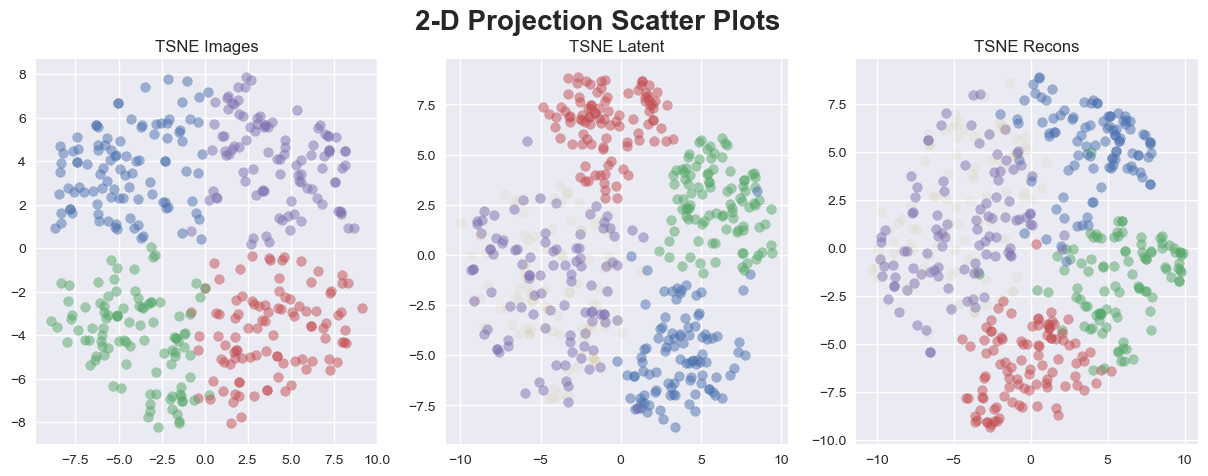

In [4]:
results_folder = os.path.join('Results', 'Test')
checkpoints_folder = os.path.join(results_folder, 'Checkpoints')
plots_folder = os.path.join(results_folder, 'Plots')
print(results_folder)
if not os.path.exists(results_folder): 
    os.makedirs(results_folder)
    os.makedirs(checkpoints_folder)
    os.makedirs(plots_folder)

train_loader, test_loader = ut.MNIST_data(class_filter=2,augs=['flip_lr', 'flip_ud'],combine=True,targets=True)
model = torch.load(os.path.join(checkpoints_folder, 'Decs_2_100.pt'),map_location=device)
ut.make_2D_video(model, test_loader, device, ['flip_lr', 'flip_ud'], 0,save_path=os.path.join(plots_folder,'Video/'))